# Intergroup Difference Explanations with G-SHAP

G-SHAP allows us to ask why model predictions differ between groups.

In this example, we train a model to predict whether a convicted criminal will reoffend within two years. The model predicts substantially higher rates of recidivism for Blacks compared with non-Blacks. We use G-SHAP to identify what variables drive this difference.

We find that the most important variables are prior convictions, age, and a low level of probation supervision.

Additionally, we create a `BlindClassifier`, which blinds our original classifier to a user-specified list of variables. In this example, we blind our model to age and race. This slightly reduces accuracy and greatly decreases racial disparities.

## Setup

In [1]:
import warnings
warnings.simplefilter('ignore')

import gshap
from gshap.datasets import load_recidivism
from gshap import intergroup
from gshap.intergroup import IntergroupDifference, BlindClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

We begin by loading the recidivism dataset (courtesy of Propublica's COMPAS analysis) and training our classifier.

In [2]:
recidivism = load_recidivism()
X, y = recidivism.data, recidivism.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000)
clf = SVC()
clf.fit(X_train, y_train)
print('Test score: %.4f' % clf.score(X_test, y_test))

Test score: 0.6720


Next we create a blind version of our classifier. The `BlindClassifier` subsitutes random values from the training dataset into the blinded columns before sending the data to the original classifier for prediction. The `BlindClassifier` repeats this for `nsamples` iterations, then outputs the modal prediction.

In [3]:
blind_clf = BlindClassifier(
    clf.predict, 
    X_train, 
    ('age','black'),
    nsamples=1
)
accuracy = accuracy_score(blind_clf.predict(X_test), y_test)
print('Test score: %.4f' % accuracy)

Test score: 0.6140


## Preliminary analysis (not essential)

First, we compute the predicted two-year recidivism rate for Black and non-Blacks using the original model and the blind model, and plot the results. Second, we plot correlations between key variables.

In [4]:
df = pd.concat((X_test, y_test), axis=1)
df['y_pred'] = clf.predict(X_test)
p_non_black, p_black = df.groupby('black')['y_pred'].mean()
print('Predicted two-year recidivism rate for non-Blacks: % .2f' % p_non_black)
print('Predicted two-year recidivism rate for Blacks: % .2f' % p_black)
print('Relative difference: % .2f' % (p_black/p_non_black - 1))

Predicted two-year recidivism rate for non-Blacks:  0.41
Predicted two-year recidivism rate for Blacks:  0.66
Relative difference:  0.62


In [5]:
df['blind_y_pred'] = blind_clf.predict(X_test)
p_non_black, p_black = df.groupby('black')['blind_y_pred'].mean()
print('Predicted two-year recidivism rate for non-Blacks: % .2f' % p_non_black)
print('Predicted two-year recidivism rate for Blacks: % .2f' % p_black)
print('Relative difference: % .2f' % (p_black/p_non_black - 1))

Predicted two-year recidivism rate for non-Blacks:  0.41
Predicted two-year recidivism rate for Blacks:  0.54
Relative difference:  0.32


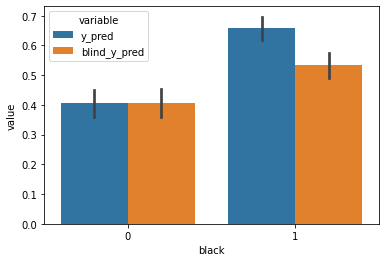

In [6]:
df['id'] = df.index
df = df.melt(('id', 'black'), value_vars=('y_pred', 'blind_y_pred'))
sns.barplot(y='value', x='black', hue='variable', data=df)
plt.show()

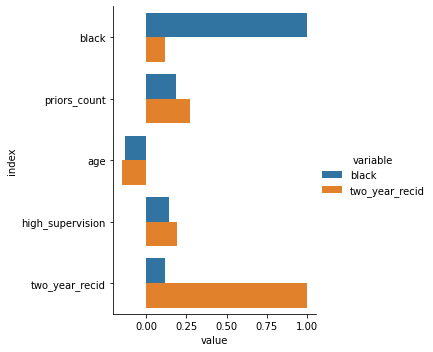

In [7]:
corr_df = recidivism.df[[
    'black', 'priors_count', 'age', 'high_supervision', 'two_year_recid'
]].corr().reset_index()
corr_df = corr_df.melt('index', value_vars=['black', 'two_year_recid'])
sns.catplot(
    x='value',
    y='index',
    hue='variable',
    data=corr_df,
    kind='bar',
    orient='h'
)
plt.show()

## G-SHAP for Intergroup Differences

Compute the G-SHAP values for our original and blind models, where $g$ is `IntergroupDifference`. This measures the relative difference in predicted recidivism rates between Blacks and non-Blacks.

In [8]:
distance = intergroup.mean_relative_distance
g = IntergroupDifference(X_test['black'], distance)
explainer = gshap.KernelExplainer(clf.predict, X_train, g)
gshap_values = explainer.gshap_values(X_test, nsamples=32)

In [9]:
explainer = gshap.KernelExplainer(blind_clf.predict, X_train, g)
blind_gshap_values = explainer.gshap_values(X_test, nsamples=32)

Finally, we display the results. This plot tells us which features drive the disparity between Blacks and non-Blacks. For our blind model, notice that the features to which the model is blind (age and race) have no effect.

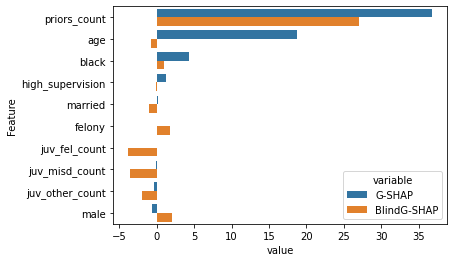

In [10]:
df = pd.DataFrame({
    'Feature': X.columns, 
    'G-SHAP': 100*gshap_values,
    'BlindG-SHAP': 100*blind_gshap_values
})
df = df.sort_values('G-SHAP', ascending=False).reset_index(drop=True)
df = df.melt('Feature', value_vars=('G-SHAP', 'BlindG-SHAP'))
sns.barplot(y='Feature', x='value', hue='variable', data=df)
plt.show()

In [17]:
df = pd.DataFrame({
    'Feature': X.columns, 
    'G-SHAP': 100*gshap_values,
    'BlindG-SHAP': 100*blind_gshap_values
})
df
# df = df.sort_values('G-SHAP', ascending=False).reset_index(drop=True)[:4]
# df = df.melt('Feature', value_vars=('G-SHAP', 'BlindG-SHAP'))
# sns.barplot(y='Feature', x='value', hue='variable', data=df)
# plt.show()

,Feature,G-SHAP,BlindG-SHAP
0,male,-0.594638,2.084564
1,age,18.802684,-0.771544
2,juv_fel_count,0.033421,-3.840467
3,juv_misd_count,-0.105220,-3.515753
4,juv_other_count,-0.353855,-1.895008
5,priors_count,36.777856,27.052925
6,felony,0.057171,1.782718
7,black,4.365974,0.970293
8,married,0.168674,-1.052628
9,high_supervision,1.236099,-0.055651
